## Sobre un Dataset de datos a elegir, se debe realizar estos ejercicios:

1. En primer lugar vamos a cargar todas librerías necesarias para el la creación y uso de la BBDD.

In [132]:
import pandas as pd
import json
import pymongo
from pymongo import MongoClient
from plotnine import *



2. Para la creación de la BBDD no relacional, vamos a utilizar el fichero pkedex en formato json. Se lee con la función open.

In [119]:
# Leemos el fichero pokedes en formato json.

with open(r'./pokedex.json', 'r') as lectura:
    
    if lectura.readable() == True:
        
        print("El fichero se puede leer.")
        
        salida = lectura.readlines()
    
    else:
        
        print('El fichero no se puede leer.')
        

El fichero se puede leer.


3. Una vez obtenidos los datos, los convertirmos a formato json y los metemos dentro de un diccionario. Se elimina la etiquite '_id' antigua.

In [120]:

# Creamos un diccionario cuya clave unitaria es el número del pokemon.

pokedex = []

for i in salida:
    linea = {}
    a= json.loads(i)
    linea['description'] = a
    linea['description'].pop('_id')
   

    pokedex.append(linea)
    

- Realizamos la conexión con MongoDB al serviror local, además, se excepcionan lso errores por tiempo y/o fallo en la conexión.

In [121]:
# Se realiza conexion al servidor local de MongoDB, se levantan errores de tiempo y/o conexión fallida.

try:
    
    conexion = MongoClient("localhost",27017,serverSelectionTimeoutMS=1000)
    print("Conexión realizada con éxito.")
    
except pymongo.errors.ServerSelectionTimeoutError as errorTiempo:
    
    print("MongoDB no responde. " + errorTiempo) 
    pass

except pymongo.errors.ConnectionFailure as errorConexión:
    
    print("Error al conectarse a MongoDB. " + errorConexión) 
    pass

Conexión realizada con éxito.


- Creación esquema. Se intenta borrar para en caso de ejecutar todo el escript no duplicar.

In [122]:
# Cracción del esquema, borra el esquema primero.

try:
    
    conexion.drop_database("Pokemon")
    dbs = conexion["Pokemon"]

except:

    dbs = conexion["Pokemon"]

- Crear colección. Se crea la colección, antes de ello, se borra para no duplicarla.

In [123]:
# Se crea la colección pokedex dentro del esquema Pokemon.En un primer lugar se borra en caso de existir.

try:
    
    dbs.drop_collection("Pokedex")
    db = dbs["Pokedex"]

except:

    db = dbs["Pokedex"]

- Insertar la colección. Se insertan los documentos uno por uno.

In [124]:
# Se inserta en la colección los datos extraidos del fichero Json. Primero borra la collección previa.

try:
    
    db.drop("Pokedex")
    for i in pokedex:
        db.insert_one(i['description'])

except:

     for i in pokedex:
        db.insert_one(i['description'])

- Se comprueba que los documentos se han insertado en la colección. Se transforman a formato tabla (DF) para su visualización.

In [125]:

query = db.find()
libro = pd.DataFrame(query)
libro.columns

Index(['_id', 'num', 'name', 'img', 'type', 'height', 'weight', 'candy',
       'candy_count', 'egg', 'spawn_chance', 'avg_spawns', 'spawn_time',
       'multipliers', 'weaknesses', 'next_evolution', 'prev_evolution'],
      dtype='object')

**Explicación de los datos.**

- _id = Número PK por cáda documento.
- num = Identificador de cada pokemon.
- name = Nombre de cada pokemon.
- img = Imagen de cada pokemon.
- type = Tipo de cada pokemon, a pesar de cada pokemon poder tener más de un tipo, el primero se considera el principal.
- height = Altura.
- weight = Peso.
- Cany = Nombre del caramelo para crear el pokemon.
- candy_count = Número de caramelos identificados.
- egg = Médida del huevo.
- spawn_chance = Probabilidad de aparición.
- avg_spawns = Probabilidad media de aparición.
- spawn_time = Hora de aparición.
- miltipliers = Multiplicador.
- weaknesses = Fortalezas.
- next_evolution = Próxima evolución.
- prev_evolution = Evolución anterior.

- Revisión de todos los pokemon que están en su fase final y no van a evolucionar más.

In [126]:
# Hacemos una query para saber el número de pokemon que no evoluciona.

where = {"next_evolution":{"$exists":False}}
select = {}

datos = db.find(where, select)

solucion = pd.DataFrame(datos)

print(f'El total de pokemon que no evoluciona es: {solucion.shape[0]} y son:\n\n{list(solucion.name)}')

El total de pokemon que no evoluciona es: 81 y son:

['Venusaur', 'Charizard', 'Butterfree', 'Blastoise', 'Beedrill', 'Raticate', 'Pidgeot', 'Fearow', 'Raichu', 'Sandslash', 'Arbok', 'Nidoqueen', 'Nidoking', 'Clefable', 'Wigglytuff', 'Golbat', 'Ninetales', 'Vileplume', 'Parasect', 'Venomoth', 'Dugtrio', 'Golduck', 'Primeape', 'Persian', 'Arcanine', 'Poliwrath', 'Alakazam', 'Victreebel', 'Machamp', 'Tentacruel', 'Golem', 'Rapidash', 'Magneton', "Farfetch'd", 'Dodrio', 'Slowbro', 'Dewgong', 'Cloyster', 'Muk', 'Gengar', 'Onix', 'Kingler', 'Hypno', 'Electrode', 'Exeggutor', 'Hitmonchan', 'Hitmonlee', 'Lickitung', 'Marowak', 'Rhydon', 'Weezing', 'Tangela', 'Chansey', 'Kangaskhan', 'Seadra', 'Mr. Mime', 'Scyther', 'Jynx', 'Electabuzz', 'Seaking', 'Starmie', 'Magmar', 'Pinsir', 'Gyarados', 'Lapras', 'Ditto', 'Tauros', 'Vaporeon', 'Jolteon', 'Flareon', 'Omastar', 'Porygon', 'Kabutops', 'Aerodactyl', 'Articuno', 'Snorlax', 'Zapdos', 'Mewtwo', 'Dragonite', 'Mew', 'Moltres']


- Se revisa también el número de pokemon que nunca han evolucionado y que tampoco están pendiente de evolución.

In [127]:
query_uno = {"next_evolution": {"$exists":False}}
query_dos = {"prev_evolution": {"$exists":False}}

where = {"$and":[query_uno, query_dos]}
select = {'name':1,'_id':0}

datos = db.find(where, select)

solucion = pd.DataFrame(datos)

print(f"El total de pokemon que no evoluciona y nunca ha evolucionado es {solucion.shape[0]} y son:")
pd.DataFrame(solucion)


El total de pokemon que no evoluciona y nunca ha evolucionado es 25 y son:


,name
0,Farfetch'd
1,Onix
2,Hitmonchan
3,Hitmonlee
4,Lickitung
5,Tangela
6,Chansey
7,Kangaskhan
8,Mr. Mime
9,Scyther


- Se identifica todos los pokemon que de tipo dragón. En el filtro se incluye el dato sliceado.

In [128]:
where = {"type":"Dragon"}
select = {"_id":0, 'name':1, 'type':{ "$slice": 1 } }



datos = db.find(where, select)
vb = pd.DataFrame(datos)

print(f'El total de Pokemo que al menos uno de sus tipos son {vb.shape[0]}: ')

vb

El total de Pokemo que al menos uno de sus tipos son 3: 


,name,type
0,Dratini,[Dragon]
1,Dragonair,[Dragon]
2,Dragonite,[Dragon]


- Vamos a realizar un pipeline para saber la probabilidad de aparción por tipo.

In [130]:
fase_uno =  { "$addFields": { "type_main": { "$first": "$type"} } } # Agregación del campo type_main para identificar el tipo principal.
fase_dos = { "$group": { "_id": "$type_main", "avg_a_swapn": { "$avg": "$spawn_chance" } } } # Agrupar por tipo principal y cálculo de media de aparición.
fase_tres = { "$sort": { "avg_a_swapn" :1 } } # Ordenar el dataframe
pipeline = [fase_uno, fase_dos, fase_tres]

salida_pipeline = db.aggregate(pipeline)

df_pipeline = pd.DataFrame(salida_pipeline)

df_pipeline

,_id,avg_a_swapn
0,Dragon,0.107033
1,Fire,0.172567
2,Ice,0.175000
3,Rock,0.181444
4,Electric,0.189622
5,Fighting,0.217686
6,Ghost,0.282900
7,Grass,0.341050
8,Ground,0.355375
9,Psychic,0.470925


- Gráfica de aparición

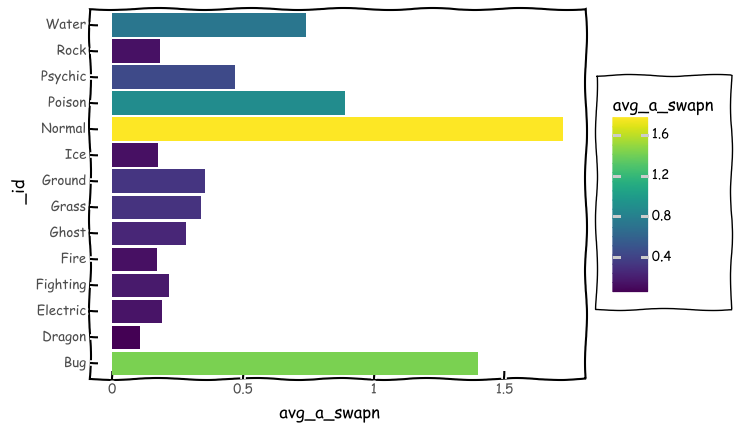

<ggplot: (141239639381)>

In [134]:

(
    ggplot(df_pipeline)
    + aes(x = '_id',
          y='avg_a_swapn',
          fill='avg_a_swapn')
    +geom_col(position ='dodge')
    + coord_flip() # gira el eje
    + theme_linedraw()
     + theme_xkcd()
    
)

**EXPLICACIÓN**

***1*** Hemos realizado la creación de la base de datos a través de Python, para ello, hemos utilizado un fichero en formato tipo json. Tras leer el fichero y parsearlo con la librería *json* hemos creado un diccionario. Este diccionario, lo hemos recorrido para poder hacer un insert de cada documento en la BBDD.

***2*** Se ha trabajado con la BBDD en funciones de filtrado para identificar el número de Pokemon que ya estaban en su fase final y así como todos los que no tienen actualización. 

***3*** Se ha generado un proceso *pipeline* para identificar según la categoría la probabilidad media de aparación.

***4*** Se ha hecho una representación gráfica de proceso pipeline.